# Общая задача и вся ситуация

Обучение с использованием трансформеров - это сложная и с точки зрения ресурсов задача. Более того, обучение далеко не так доступно для пользователей, чем работа с CNN и RNN.

Тем не менее, многое мы будем делать в знакомом формате. Обучать свою модель в любом случае "зло" для прикладной задачи. Потому мы будем брать модели с huggingface.

Основная проблема всей истории с трансформерами в том, что в реальности в них триллионы параметров, которые нам всё равно никогда не запустить.

Это формирует достаточно серьёзную проблему доступности технологий ИИ для человека.

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

# https://github.com/huggingface/transformers
# обучение, загрузка по формату библиотеки, оптимизаторы
!pip install -qq transformers
!pip install -qq datasets
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, AdamW, get_scheduler
import torch
from torch.utils.data import DataLoader
from sklearn import preprocessing
from sklearn.metrics import classification_report
from tqdm import tqdm
import gc
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

## Набор данных

Kinopoisk movie reviews dataset (TOP250 & BOTTOM100 rank lists).

https://huggingface.co/datasets/blinoff/kinopoisk

In [ ]:
!wget https://huggingface.co/datasets/blinoff/kinopoisk/resolve/main/kinopoisk.jsonl

--2024-03-30 14:32:50--  https://huggingface.co/datasets/blinoff/kinopoisk/resolve/main/kinopoisk.jsonl
Resolving huggingface.co (huggingface.co)... 18.172.134.4, 18.172.134.24, 18.172.134.124, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/d5/15/d51582521abb225a9c3a389f2b2d765197b8a85b7508a70a9e5f3ee14807db31/15bbd1ec69610aa77e853a61823872c825239ba4daa0ad77b4244a682cfedf1c?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27kinopoisk.jsonl%3B+filename%3D%22kinopoisk.jsonl%22%3B&Expires=1712068370&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxMjA2ODM3MH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy9kNS8xNS9kNTE1ODI1MjFhYmIyMjVhOWMzYTM4OWYyYjJkNzY1MTk3YjhhODViNzUwOGE3MGE5ZTVmM2VlMTQ4MDdkYjMxLzE1YmJkMWVjNjk2MTBhYTc3ZTg1M2E2MTgyMzg3MmM4MjUyMzliYTRkYWEwYWQ3N2I0MjQ0YTY4MmNmZWRmMWM%

In [ ]:
df = pd.read_json('/content/kinopoisk.jsonl', lines=True)

In [ ]:
df.head()

,part,movie_name,review_id,author,date,title,grade3,grade10,content
0,top250,Блеф (1976),17144,Come Back,2011-09-24,Плакали наши денежки ©,Good,10.0,"\n""Блеф» — одна из моих самых любимых комедий...."
1,top250,Блеф (1976),17139,Stasiki,2008-03-04,None,Good,0.0,\nАдриано Челентано продолжает радовать нас св...
2,top250,Блеф (1976),17137,Flashman,2007-03-04,None,Good,10.0,"\nНесомненно, это один из великих фильмов 80-х..."
3,top250,Блеф (1976),17135,Sergio Tishin,2009-08-17,""" Черное, красное, ерунда это все. Выигрывает ...",Good,0.0,\nЭта фраза на мой взгляд отражает сюжет несом...
4,top250,Блеф (1976),17151,Фюльгья,2009-08-20,"«Он хотел убежать? Да! Блеф, блеф…»",Neutral,7.0,"\n- как пела Земфира, скорее всего, по соверше..."


Мы сильно уменьшим размер используемых данных. Это сильно скажется на результате. Но если у вас есть несколько часов - верните на исходную параметры и обучите модель.

In [ ]:
df = df[30000:31000]

In [ ]:
df['grade3'].value_counts()

Good       635
Bad        225
Neutral    140
Name: grade3, dtype: int64

In [ ]:
df[['content', 'grade3']]

,content,grade3
30000,\nПациент: кинотрилогия Пираты Карибского Моря...,Good
30001,\nДавно я не пересматривала Пиратов Карибского...,Good
30002,\nТретья часть намного уступает первым двух. Х...,Good
30003,"\nБлагодаря таким блокбастерам, как «Пираты Ка...",Good
30004,"\n-Это безумие! -Это политика!(с)\n\nНаверное,...",Good
...,...,...
30995,"\n Здесь все, как в доброй детской сказке...",Bad
30996,\n Лучше бы Кончаловский снял это 40 лет ...,Bad
30997,\n В отличии от многих здешних рецензенто...,Good
30998,\n «Щелкунчик и Крысиный король» — это та...,Neutral


In [ ]:
df = df[['content', 'grade3']]
df.columns = ['text', 'labels']
df.head()

,text,labels
30000,\nПациент: кинотрилогия Пираты Карибского Моря...,Good
30001,\nДавно я не пересматривала Пиратов Карибского...,Good
30002,\nТретья часть намного уступает первым двух. Х...,Good
30003,"\nБлагодаря таким блокбастерам, как «Пираты Ка...",Good
30004,"\n-Это безумие! -Это политика!(с)\n\nНаверное,...",Good


<Axes: >

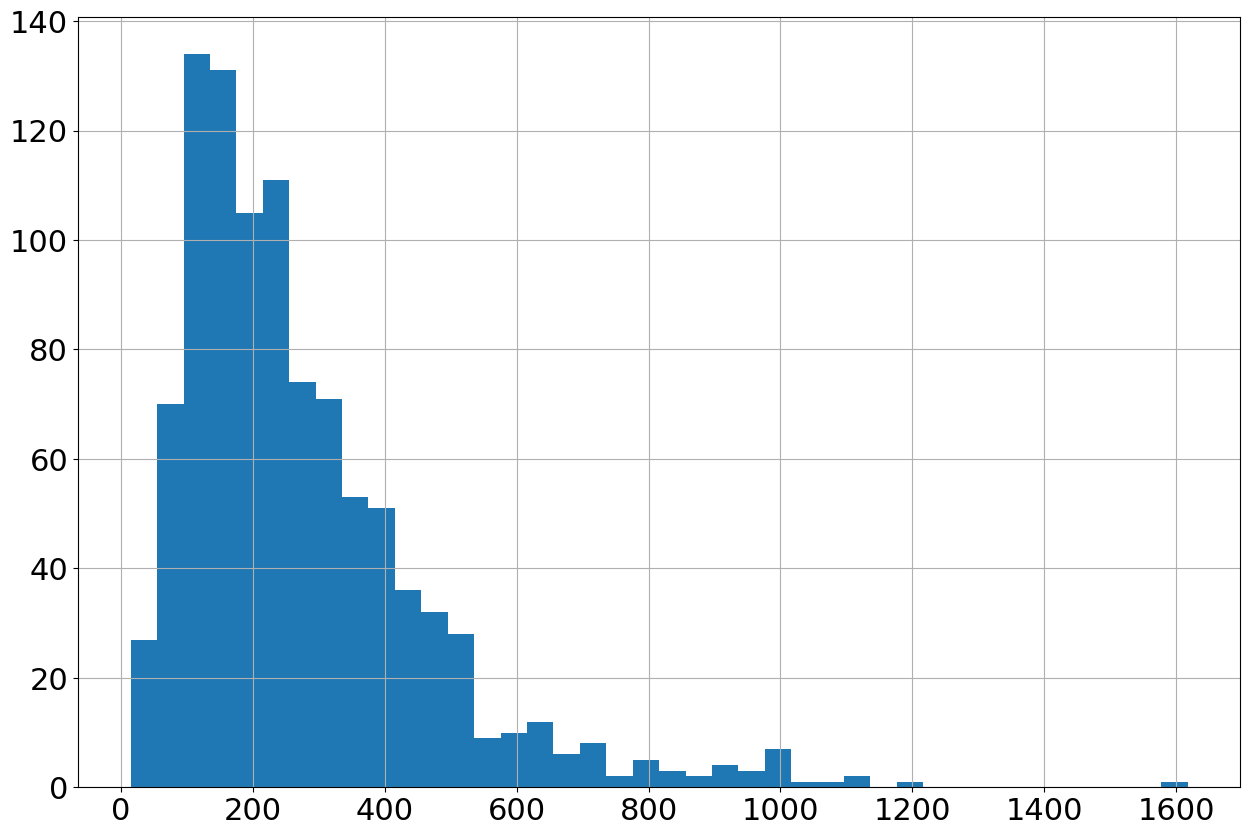

In [ ]:
df['text'].apply(lambda x: len(x.split())).hist(figsize=(15, 10), bins=40)

In [ ]:
labels2num = {
    'Good': 0,
    'Bad': 1,
    'Neutral': 2,
}

num2labels = {
    0: 'Good',
    1: 'Bad',
    2: 'Neutral',
}

In [ ]:
df['labels'] = df['labels'].map(labels2num)

In [ ]:
df

,text,labels
30000,\nПациент: кинотрилогия Пираты Карибского Моря...,0
30001,\nДавно я не пересматривала Пиратов Карибского...,0
30002,\nТретья часть намного уступает первым двух. Х...,0
30003,"\nБлагодаря таким блокбастерам, как «Пираты Ка...",0
30004,"\n-Это безумие! -Это политика!(с)\n\nНаверное,...",0
...,...,...
30995,"\n Здесь все, как в доброй детской сказке...",1
30996,\n Лучше бы Кончаловский снял это 40 лет ...,1
30997,\n В отличии от многих здешних рецензенто...,0
30998,\n «Щелкунчик и Крысиный король» — это та...,2


In [ ]:
# перемешиваем и рабиваем на train test
df = df.sample(frac=1).reset_index(drop=True)
train = df[:int(len(df)*0.8)]
test =  df[int(len(df)*0.8):]

In [ ]:
len(train), len(test)

(800, 200)

In [ ]:
# проверяем что кол-во классов всего df == кол-ву классов train
print(len(train['labels'].value_counts()))
train

3


,text,labels
0,"\n«День Сурка», относится к такому ряду фильмо...",0
1,"\nОригинальный сюжет, превосходное исполнение,...",0
2,"\nЭто не просто мультфильм, друзья мои. Это ше...",0
3,\n Сюжет: Прошло ровно сто лет после той ...,1
4,\n Предыстория\n\n\n\nВ 2007 г. я узнал с...,1
...,...,...
795,"\nЭтот фильм я пересматривал много раз, впервы...",2
796,"\n Хочу сразу предупредить, что все, что ...",2
797,"\nНесмотря на то, что я не люблю Черную Жемчуж...",2
798,\nНикогда не была страстным поклонником аниме....,0


In [ ]:
# проверяем что кол-во классов всего df == кол-ву классов test
print(len(test['labels'].value_counts()))

3


In [ ]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

## Скачивание модели

In [ ]:
model_name = "sberbank-ai/sbert_large_nlu_ru"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/sbert_large_nlu_ru and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
names = list(model.named_parameters())
names[:6]

[('bert.embeddings.word_embeddings.weight',
  Parameter containing:
  tensor([[ 0.0606, -0.0615,  0.0168,  ..., -0.0138, -0.0484, -0.0585],
          [ 0.0038, -0.0852,  0.0023,  ..., -0.0053,  0.0156, -0.0284],
          [ 0.0240, -0.0408, -0.0073,  ..., -0.0014,  0.0304,  0.0227],
          ...,
          [ 0.0440, -0.0153,  0.0383,  ..., -0.0643, -0.0344, -0.0135],
          [ 0.0465, -0.0162,  0.0522,  ..., -0.0459,  0.0222, -0.0480],
          [ 0.0326,  0.0194,  0.0508,  ...,  0.0417, -0.0545, -0.0163]],
         requires_grad=True)),
 ('bert.embeddings.position_embeddings.weight',
  Parameter containing:
  tensor([[ 3.9556e-04,  1.1412e-02, -7.9491e-03,  ..., -2.6713e-04,
           -3.0242e-03, -1.2221e-02],
          [-4.3789e-03,  8.2686e-03,  7.2317e-03,  ...,  5.0034e-03,
            2.9022e-03,  1.4276e-03],
          [ 5.3956e-03,  2.1844e-02,  1.8691e-02,  ..., -1.1598e-03,
           -3.7614e-03, -3.7767e-05],
          ...,
          [-4.0377e-03, -8.1262e-03, -1.7772e

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

46

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

device(type='cuda')

In [ ]:
dataset = load_dataset('csv', data_files={'train': 'train.csv', 'test': 'test.csv'})

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset = dataset.map(lambda e: tokenizer(e['text'], truncation = True, max_length=511, padding='max_length'), batched=True)

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

BERT'у нужно предоставить специальный формат входных данных.


- **input ids**: последовательность чисел, отождествляющих каждый токен с его номером в словаре.
- **labels**: вектор из нулей, единиц и двоек. В нашем случае нули обозначают позитивную эмоциональную окраску, единицы - нейтральную, двойки - негативную.
- **attention mask**: (необязательно) последовательность нулей и единиц, где единицы обозначают токены предложения, нули - паддинг.
- **token_type_ids** Указывает яляется ли последовательность «контекстом», используемый для вопроса (все токены 0) или «вопросому» (все токены 1).

In [ ]:
# это стандартные колонки для формата пайторча, все кроме них убираем
pytorch_style_columns = ['input_ids', 'token_type_ids', 'attention_mask', 'labels']  #
# убираем их из загрузчика
dataset = dataset.remove_columns(list(set(list(dataset['train'].features.keys())) - set(pytorch_style_columns)))

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 800
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 200
    })
})

In [ ]:
dataset.set_format(type='torch', columns=pytorch_style_columns, device='cuda')


In [ ]:
train_dataloader = DataLoader(dataset['train'], shuffle=True, batch_size=3)
test_dataloader = DataLoader(dataset['test'], shuffle=False, batch_size=1)

In [ ]:
len(train_dataloader)

267

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-6)
num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)

lr_scheduler = get_scheduler(
    "constant_with_warmup",
    optimizer=optimizer,
    num_warmup_steps=2000,
    num_training_steps=num_training_steps
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
next(iter(train_dataloader))

{'labels': tensor([0, 1, 0], device='cuda:0'),
 'input_ids': tensor([[  101,   118,  1721,  ...,     0,     0,     0],
         [  101,  1040,   119,  ...,     0,     0,     0],
         [  101,  6135,   119,  ...,  1090, 29104,   102]], device='cuda:0'),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1]], device='cuda:0')}

In [ ]:
from tqdm.auto import tqdm
from collections import deque

best_f1 = 0.
avg_loss = deque([], maxlen=30)

# проходимся по всем эпохам
for epoch in range(num_epochs):
    print(40*'-', '\nepoch', epoch+1)
    model.train()

    with tqdm(train_dataloader, unit="batch") as tepoch:
        for batch in tepoch:
            model.train()
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            avg_loss.append(loss.item())
            tepoch.set_postfix(loss=np.array(list(avg_loss)).mean())

    losses = []
    print('\nvalidating')
    f1 = load_metric('f1')
    acc = load_metric('accuracy')
    precision = load_metric('precision')
    recall = load_metric('recall')
    with torch.no_grad():
        model.eval()
        for batch in tqdm(test_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            f1.add_batch(predictions=predictions, references=batch["labels"])
            acc.add_batch(predictions=predictions, references=batch["labels"])
            precision.add_batch(predictions=predictions, references=batch["labels"])
            recall.add_batch(predictions=predictions, references=batch["labels"])
        print('weighted summary:')
        print('Test acc:', acc.compute()['accuracy'])
        print('Test precision:', precision.compute(average = 'macro')['precision'])
        print('Test recall:', recall.compute(average = 'macro')['recall'])
        f1_weighted = f1.compute(average = 'macro')['f1']
        print('Test f1:', f1_weighted, '\n')
        if f1_weighted > best_f1:
            best_f1 = f1_weighted
            model.save_pretrained(f"best_model_f1_max={best_f1}_len=511")

    model.train()

---------------------------------------- 
epoch 1


  0%|          | 0/267 [00:00<?, ?batch/s]


validating


<ipython-input-33-8e58d9348a7d>:50: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  f1 = load_metric('f1')
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for precision contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/precision/precision.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for recall contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/recall/recall.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

weighted summary:
Test acc: 0.615
Test precision: 0.38321608040201005
Test recall: 0.615
Test f1: 0.47219814241486074 



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
true = []
preds = []

model.eval()
for batch in tqdm(test_dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    true += batch["labels"].detach().cpu().numpy().tolist()
    preds += predictions.detach().cpu().numpy().tolist()

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
true = [num2labels[e] for e in true]
preds = [num2labels[e] for e in preds]
print(classification_report(true, preds))

              precision    recall  f1-score   support

         Bad       0.00      0.00      0.00        41
        Good       0.62      0.99      0.76       124
     Neutral       0.00      0.00      0.00        35

    accuracy                           0.61       200
   macro avg       0.21      0.33      0.25       200
weighted avg       0.38      0.61      0.47       200



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
